Eodag basics
===========

We present the two basic features of eodag : search and download.

Let's start by setting your personal credentials to access [peps service](https://peps.cnes.fr) by filling your username and password bellow:

In [1]:
import os
import sys

os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = "samuel.foucher@crim.ca"
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = "2Wsx3edc!"

Then we create a workspace directory where all our files and configuration will live:

In [2]:
workspace = 'eodag_workspace'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

Next, we consider that we have a configuration file sitting in our workspace called `eodag_conf.yml`, with this minimalist content:

    peps:
        download:
            outputs_prefix: <absolute_path_to_eodag_workspace>
            extract: true
    
The rest of the configuration is the providers credentials given as described in the documentation.

The first step is to initialize the session by creating an `EODataAccessGateway` instance, with the previous configuration file:

In [3]:
# To have some basic feedback on what eodag is doing, we configure logging to output minimum information
from eodag.utils.logging import setup_logging
setup_logging(verbose=1)

from eodag.api.core import EODataAccessGateway

dag = EODataAccessGateway()

2020-04-28 15:09:29,842-15s eodag.config                     [INFO    ] Loading user configuration from: /home/jovyan/.config/eodag/eodag.yml


Now let's search for Sentinel 2 L1C products in the South of France:

In [12]:
from datetime import date
product_type = 'S1_SAR_SLC'
extent = {
    'lonmin': -76.607666015,
    'lonmax': -72.586669921,
    'latmin': 44.69208804172,
    'latmax': 46.32417161725
}

products, estimated_total_nbr_of_results = dag.search(
    productType=product_type,
    start='2020-04-01',
    end=date.today().isoformat(),
    box=extent
)

2020-04-28 15:21:45,083-15s eodag.core                       [INFO    ] Searching product type 'S1_SAR_SLC' on provider: peps
2020-04-28 15:21:45,085-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://peps.cnes.fr/resto/api/collections/S1/search.json?productType=SLC&startDate=2020-04-01&completionDate=2020-04-28&box=-76.607666015,44.69208804172,-72.586669921,46.32417161725&maxRecords=1&page=1
2020-04-28 15:21:45,887-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S1/search.json?productType=SLC&startDate=2020-04-01&completionDate=2020-04-28&box=-76.607666015,44.69208804172,-72.586669921,46.32417161725&maxRecords=20&page=1
2020-04-28 15:21:47,252-15s eodag.core                       [INFO    ] Found 22 result(s) on provider 'peps'


Now that we have found some products, we can store the search result in a geojson file that will be used for later download:

In [5]:
search_result_file = dag.serialize(products, filename=os.path.join(workspace, 'search_results.geojson'))

In [10]:
for p in products:
    print('{}: orbit: {} relativeOrbitNumber: {}'.format(p.properties['title'],p.properties['orbitDirection'],p.properties['relativeOrbitNumber']))
product = products[1]

S1A_IW_SLC__1SDV_20200426T225249_20200426T225316_032305_03BCF6_0DB2: orbit: ascending relativeOrbitNumber: 33
S1A_IW_SLC__1SDV_20200426T225224_20200426T225251_032305_03BCF6_F9D6: orbit: ascending relativeOrbitNumber: 33
S1A_IW_SLC__1SDV_20200426T225200_20200426T225227_032305_03BCF6_8028: orbit: ascending relativeOrbitNumber: 33
S1B_IW_SLC__1SDV_20200425T230012_20200425T230041_021307_02871A_A202: orbit: ascending relativeOrbitNumber: 106
S1A_IW_SLC__1SDV_20200421T224414_20200421T224441_032232_03BA74_8E38: orbit: ascending relativeOrbitNumber: 135
S1A_IW_SLC__1SDV_20200421T224349_20200421T224416_032232_03BA74_5614: orbit: ascending relativeOrbitNumber: 135
S1A_IW_SLC__1SDV_20200420T105626_20200420T105656_032210_03B9AC_C0D6: orbit: descending relativeOrbitNumber: 113
S1A_IW_SLC__1SDV_20200419T230024_20200419T230101_032203_03B96F_DA89: orbit: ascending relativeOrbitNumber: 106
S1A_IW_SLC__1SDV_20200416T223611_20200416T223638_032159_03B7DB_4D6E: orbit: ascending relativeOrbitNumber: 62
S1A_

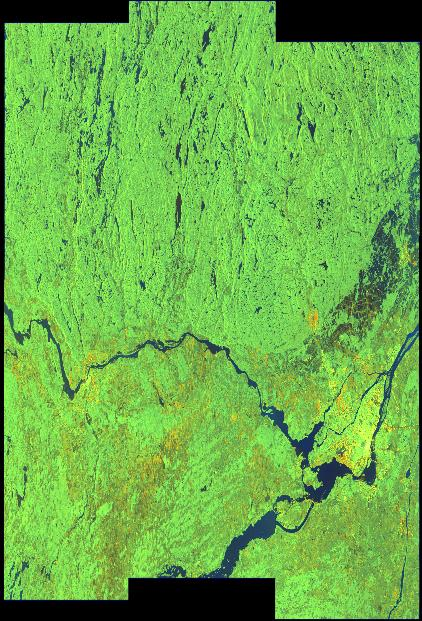

In [14]:
from IPython.display import display, Image

#product_path = product_path[7:] if product_path.startswith('file://') else product_path
Image('https://peps.cnes.fr/quicklook/2020/04/02/S1A/S1A_IW_SLC__1SDV_20200402T225223_20200402T225250_031955_03B0A8_1B2F_quicklook.jpg')

We can check the extents of the products before downloading them by using ipyleaflet API:

In [7]:
import ipyleaflet as ipyl

m = ipyl.Map(center=[45, -74], zoom=5)
layer = ipyl.GeoJSON(data=products.as_geojson_object(), hover_style={'fillColor': 'yellow'})

m.add_layer(layer)
m

Map(center=[45, -74], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

Finally, we can download from the eodag SearchResult object `products`, (or from the GeoJson previously created):

In [8]:
from eodag.utils import ProgressCallback
from tqdm.notebook import tqdm

# Create a custom progressbar callback
class NotebookProgressCallback(ProgressCallback):
    
    def __call__(self, current_size, max_size):
        if self.pb is None:
            self.pb = tqdm(total=max_size, unit='KB', unit_scale=True)
        self.pb.update(current_size)


# Download the first product found
path = dag.download(products[0], progress_callback=NotebookProgressCallback())

2020-04-28 15:00:09,174-15s eodag.plugins.download.http      [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S1/4c9e72a5-1e40-5e4a-830f-78bcb66b02e7/download


KeyboardInterrupt: 

This concludes the tutorial for the basic usage of eodag.